In [ ]:
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

# !pip install wandb
# !pip install thop

In [10]:
import torch

from kws.trainer import Trainer
from kws.config import UncompressedConfig, SmallConfig
from kws.models import CRNN, StreamCRNN
from test_performance import test_preformance

Train base model to good quality for 50 epochs.

In [2]:
base_config = UncompressedConfig()
# trainer = Trainer(base_config)
# trainer.train()

Now use it for Knowledge Distillation as a Teacher model.

In [3]:
student_config = SmallConfig()

# trainer = Trainer(base_config)
# trainer.train_distilled(student_config, teacher_checkpoint='teacher_model.pth')

To compress model even more use dynamic quantization.

In [4]:
best_student_checkpoint = 'solar-donkey-22-45-0.0000455_distill_model.pth'
best_base_checkpoint = 'cool-haze-8-27-0.0000_model.pth'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

base_model = CRNN(base_config)
distill_model = CRNN(student_config)
base_model.load_state_dict(torch.load(best_base_checkpoint, map_location=device))
distill_model.load_state_dict(torch.load(best_student_checkpoint, map_location=device))
quantized_base_model = torch.quantization.quantize_dynamic(base_model, dtype=torch.float16)
quantized_distilled_model = torch.quantization.quantize_dynamic(distill_model, dtype=torch.float16)

/Users/egoriya/miniconda/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/egoriya/miniconda/lib/python3.9/site-packages/torch/ao/nn/quantized/dynamic/modules/rnn.py:89: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Now let's test our models performance.

In [5]:
import torch.nn.utils.prune as prune

In [6]:
pruned_model = CRNN(base_config)
pruned_model.load_state_dict(torch.load(best_base_checkpoint, map_location=device))

module = pruned_model.conv[0]

prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)

test_preformance(base_config, pruned_model)

102it [00:18,  5.44it/s]


{'memory': 0.10677528381347656,
 'au_fa_fr': 0.00013122040376128556,
 'time': 0.006090968262915518,
 'MACs': 54911167.058823526,
 'num_params': 25387}

Pruning drops metric so much so we do not include it in final comparison of compression methods.

In [7]:
uncompressed_res = test_preformance(base_config, base_model)

comp_dict = dict(
    quantized_base_res = test_preformance(base_config, quantized_base_model),
    distill_res = test_preformance(student_config, distill_model),
    quantized_distill_res = test_preformance(student_config, quantized_distilled_model),
)

for name, cmp in comp_dict.items():
    print(f'Experiment name: {name}')
    for key in uncompressed_res:
        print('{} reduced by {:.6f}'.format(key, uncompressed_res[key] / cmp[key]))
    print('###\n###')

102it [00:14,  7.18it/s]
102it [00:14,  6.93it/s]
102it [00:13,  7.37it/s]
102it [00:14,  7.11it/s]


Experiment name: quantized_base_res
memory reduced by 0.923332
au_fa_fr reduced by 0.999602
time reduced by 0.740992
MACs reduced by 2.731515
num_params reduced by 31.419554
###
###
Experiment name: distill_res
memory reduced by 3.625547
au_fa_fr reduced by 1.339848
time reduced by 1.786345
MACs reduced by 2.699476
num_params reduced by 4.222721
###
###
Experiment name: quantized_distill_res
memory reduced by 2.856628
au_fa_fr reduced by 1.340325
time reduced by 1.126476
MACs reduced by 4.370424
num_params reduced by 50.271287
###
###


## Streaming

We can use our model in streaming mode. To do so we need to initialize StreamCRNN model with pretrained weights. After that we can apply model to raw audio.

In [30]:
from pathlib import Path
import torchaudio
import matplotlib.pyplot as plt


def streaming_inference(streaming_model, audio, device, slice_len=100):
    history = []
    for step in range(slice_len, audio.size(-1) + 1, slice_len):
        window = audio[:, step-slice_len:step].to(device)
        probs = streaming_model.process(window)
        history.append(probs[0][1])
    plt.plot(history)
    plt.title("Keyword prob")
    plt.xlabel("Slice")
    plt.ylabel("Prob")

In [9]:
CURRENT_DIR = Path().absolute().resolve()

keywords = [
    "on", "sheila", "off", "nine", "sheila", "six"
]

big_audio = torch.Tensor([])

for word in keywords:
    try:
        path = CURRENT_DIR / f"speech_commands/{word}/004ae714_nohash_0.wav"
        audio, _ = torchaudio.load(path)
    except:
        continue
    big_audio = torch.cat((big_audio, audio), dim=-1)

In [33]:
import torch
import torch.nn.functional as F
from kws.models import CRNN
from kws.augmentations import LogMelspec

class StreamCRNN(CRNN):
    '''
        Streaming version of CRNN.
    '''

    def __init__(self, config):
        super().__init__(config)

        self.mel_processor = LogMelspec(False, config)
        self.raw_cache = torch.Tensor([])
        self.max_window_length = config.max_window_length
        self.streaming_step_size = config.streaming_step_size
        self.prev_hidden = None
        self.prev_prob = torch.zeros(1, 2)
        self.processed_steps = 0

    @torch.no_grad()
    def process(self, raw_audio: torch.Tensor):
        self.raw_cache = torch.cat([self.raw_cache, raw_audio], dim=-1)[:, -self.max_window_length:]
        self.processed_steps += raw_audio.size(-1)

        if self.processed_steps >= self.streaming_step_size:
            self.processed_steps = 0
            melspec = self.mel_processor(self.raw_cache)
            logits, self.prev_hidden = super().forward(melspec, hiddens=self.prev_hidden)
            self.prev_prob = F.softmax(logits, dim=-1)

        return self.prev_prob

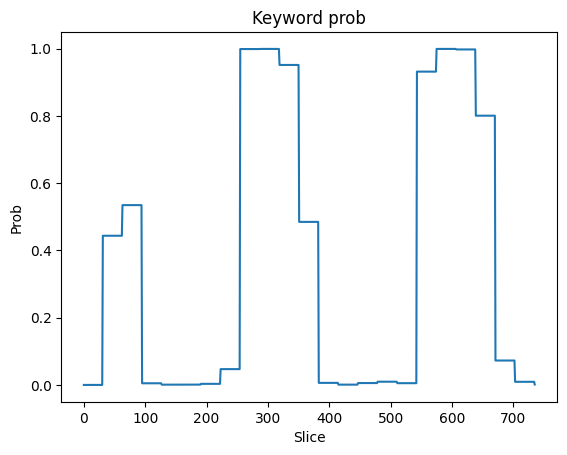

In [34]:
streaming_config = UncompressedConfig()
streaming_config.max_window_length = 8000
streaming_config.streaming_step_size = 3200
streaming_model = StreamCRNN(streaming_config).to(device)
streaming_model.load_state_dict(torch.load('teacher_model.pth', map_location=device))
streaming_model.eval()

streaming_inference(streaming_model, big_audio, device)